In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def required_funcs(alpha, beta, z1, z2, L, R, V, lmbd):
    # zeroth order terms:
    c100_a = (1 - alpha) * L + alpha * R
    c100_b = (1 - beta) * L + beta * R
    phi00_a = (np.log(c100_a) - np.log(R)) / (np.log(L) - np.log(R)) * V
    phi00_b = (np.log(c100_b) - np.log(R)) / (np.log(L) - np.log(R)) * V
    
    
    # first order terms in Q (d=0):
    c101_a = (z2  * alpha  *  (phi00_b - phi00_a) / (z1 - z2)) - (1 / (2 * (z1 - z2)))
    c101_b = (z2 * (1-beta) * (phi00_a - phi00_b) / (z1 - z2)) - (1 / (2 * (z1 - z2)))
    c201_a = z1  * alpha  *  (phi00_b - phi00_a) / (z2 - z1) - 1 / (2 * (z2 - z1))
    #capital_phi =  phi00_a - phi00_b
    phi10_a = (( (lmbd * z1 - z2) * (L - R) * V) / (z1 * z2 * np.log(L / R)) * 
                (((alpha * (c100_a + R) ) / c100_a) - 
                (2 / np.log(L / R) )* np.log(L / c100_a)) + 
                (((1 - lmbd) * (L - R)) / (z1 * z2 * np.log(L / R))) * np.log(L / c100_a) - 
                (((1 - lmbd) * alpha * (L - R)) / (z1 * z2)))

    phi10_b = (( (lmbd * z1 - z2) * (L - R) * V) / (z1 * z2 * np.log(L / R)) * 
                (((beta - 1) * (c100_b + L) ) / c100_b) - 
                (2 / np.log(L / R) * np.log(R / c100_b)) + 
                (((1 - lmbd) * (L - R)) / (z1 * z2 * np.log(L / R))) * np.log(R / c100_b) + 
                (((1 - lmbd) * (1 - beta) * (L - R)) / (z1 * z2)))


    # first order terms in Qd:
   
                
    c111_a = (2 * (lmbd * z1 - z2) * alpha * (phi00_a - phi00_b)) / (z2 * (z1 - z2)) * \
         ((2 * beta - alpha - 1) * L + (alpha ** 2 - beta ** 2) * (L - R) - beta * R) - \
         ((1 - lmbd) * (L - R) * alpha * (alpha - beta)) / (2 * z1 * (z1 - z2)) + \
         (2 * (lmbd * z1 - z2) / z2) * ((1 - alpha) * c101_a * c100_a + alpha * c101_b * c100_b) + \
         ((lmbd * (z1 - z2) + lmbd * z1 - z2) / (2 * z2 * (z1 - z2))) * ((1 - alpha) * c100_a + alpha * c100_b) - \
         (z2 * alpha / (z1 - z2)) * (phi10_a - phi10_b)

    # zero-current flux J_1=J_2=J_k
    H = 1
    alpha = 1/3
    Q = 0.001

    
    c200_a = -z1 * c100_a /z2
    
    c_10_a = c100_a + c101_a * Q
    c_20_a = c200_a + c201_a * Q
    A = np.sqrt(c_10_a * c_20_a)
    
    J_10_0 = (L - R) / H
    J_10_1 = -(A - L) / (alpha * H)
    #J_11_0 = ((lmbd + 1) / H) * (l ** 2 - r ** 2)
                 
              

    c211_a = -z1 * c111_a / z2

    return c100_a, c101_a, c111_a, c211_a, J_10_0, J_10_1



In [2]:
def fluxes(alpha, beta, z1, z2, L, R, V, lmbd, d):
    c100_a, c101_a, c111_a, c211_a, J_10_0, J_10_1 = required_funcs(alpha, beta, z1, z2, L, R, V, lmbd)
    
    
    M00 = ((lmbd * z1 - z2) / (z1 ** 2 * z2)) * alpha * (R ** 2 - L ** 2)
    M01 = ((2 * (lmbd * z1 - z2) / z2 )* c101_a * c100_a + (lmbd / (2 * z2)) * c100_a + 
           ((lmbd * z1 - z2) / (2 * z2 * (z1 - z2))) * c100_a + 
           (z2 / (z1 - z2)) * (c111_a + c211_a))
    
    J110 = 1 / (z1 * H) * M00
    J111 = 1 / (z1 * H) * M01
    J211 = (-z1/z2)*J111
    Q = 0.01
    
    J_1 = J_10_0 + J_10_1 * Q + J110 * d
    
    J_1effect = J_1 * J111
    J_1d_effect = J110 * J111
    
    return J110, J111, J211, J_1, J_1effect, J_1d_effect


In [3]:
# Identify consecutive indices and keep one element per consecutive sequence with minimum absolute value
def keep_min_abs_per_consecutive(indices, values):
    result_indices = []
    i = 0
    while i < len(indices):
        j = i + 1
        while j < len(indices) and indices[j] == indices[j - 1] + 1:
            j += 1

        # Find the index with minimum absolute value in the consecutive sequence
        min_abs_index = min(range(i, j), key=lambda k: abs(values[indices[k]]))
        result_indices.append(indices[min_abs_index])
        i = j

    return np.array(result_indices)


In [4]:
def remove_close_roots(V_zero, V_range,  distance_threshold=1e-6):
    if len(V_zero) == 0:
        return V_zero
    
    sorted_indices = np.searchsorted(V_range, V_zero)
    #sorted_roots = V_zero[sorted_indices]

    result_indices = [sorted_indices[0]]
    
    for i in range(1, len(sorted_indices)):
        distance = V_range[sorted_indices[i]] - V_range[result_indices[-1]]

        if distance >= distance_threshold:
            result_indices.append(sorted_indices[i])
            #print('1=', V_range[sorted_roots[i]])

        elif distance < distance_threshold and abs(V_range[sorted_indices[i]]) < abs(V_range[result_indices[-1]]):
            result_indices.pop()  # Remove the last added index
            result_indices.append(sorted_indices[i])
            #print('2=', x_values[sorted_roots[i]])

        #else:
         #       result_indices.append(sorted_indices[-1])
                #print('3=', x_values[sorted_roots[-1]])

    return V_range[np.array(result_indices)]


In [5]:
def remove_same_sign_points(V_zero, V_range, J1_prd2, J2_prd2):
    new_V_zero = []

    LHS_index = np.abs(V_range - (V_zero[0] - 10) ).argmin()
    mid_0_1 = (V_zero[0] + V_zero[1]) / 2
    mid_0_1_index = np.abs(V_range - mid_0_1).argmin()
    sign_J1_prd2_LHS = np.sign(J1_prd2[LHS_index])
    sign_J2_prd2_LHS = np.sign(J2_prd2[LHS_index])
    sign_J1_prd2_0_1 = np.sign(J1_prd2[mid_0_1_index])
    sign_J2_prd2_0_1 = np.sign(J2_prd2[mid_0_1_index])

    if sign_J1_prd2_LHS != sign_J1_prd2_0_1 or sign_J2_prd2_LHS != sign_J2_prd2_0_1:
        new_V_zero.append(V_zero[0])


    for i in range(1, len(V_zero) - 1):
        midpoint_prev = (V_zero[i - 1] + V_zero[i]) / 2
        midpoint_next = (V_zero[i + 1] + V_zero[i]) / 2
        mid_index_prev = np.abs(V_range - midpoint_prev).argmin()
        mid_index_next = np.abs(V_range - midpoint_next).argmin()

        # Append the signs for the current midpoint
        sign_J1_prd2_prev = np.sign(J1_prd2[mid_index_prev])
        sign_J2_prd2_prev = np.sign(J2_prd2[mid_index_prev])
        sign_J1_prd2_next = np.sign(J1_prd2[mid_index_next])
        sign_J2_prd2_next = np.sign(J2_prd2[mid_index_next])

        threshold_value = 1e-4

        if (
            sign_J1_prd2_prev != sign_J1_prd2_next or
            sign_J2_prd2_prev != sign_J2_prd2_next
            ) and (
            abs(J1_prd2[mid_index_prev]) > threshold_value and
            abs(J2_prd2[mid_index_prev]) > threshold_value and
            abs(J1_prd2[mid_index_next]) > threshold_value and
            abs(J2_prd2[mid_index_next]) > threshold_value
            ):
            new_V_zero.append(V_zero[i])



    RHS_index = np.abs(V_range - (V_zero[-1] + 10) ).argmin()
    sign_J1_prd2_RHS = np.sign(J1_prd2[RHS_index])
    sign_J2_prd2_RHS = np.sign(J2_prd2[RHS_index])
    if sign_J1_prd2_next != sign_J1_prd2_RHS or sign_J2_prd2_next != sign_J2_prd2_RHS:
        new_V_zero.append(V_zero[-1])


    return np.array(new_V_zero)


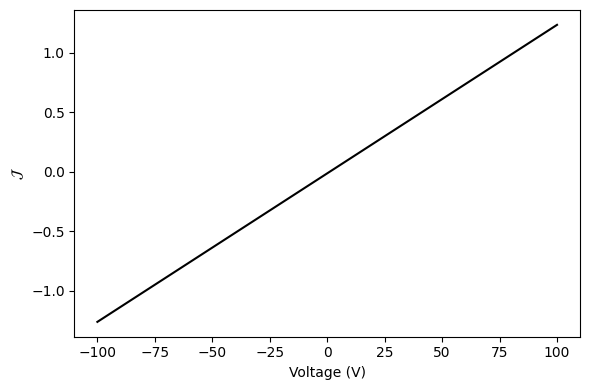

In [6]:
# Define the ranges for L and R
L = 0.1
R = 1
H = 1
d = 1e-7 # For sodium ion (Na⁺) and chloride ion (Cl⁻), the approximate ionic radiuses 
         # are around 0.95 Å and around 1.81 Å (angstroms), respectively.

V_ranges = np.linspace(-100, 100, 500)
#Q_values = [0.001, 0.005]  # Changed to two values for Q_values
alpha = 1/3
beta = 2/3
z1 = 1
z2 = -1
lmbd = 0.01
J_values = []

# Calculate J1_prd2 and J2_prd2 for each V_range and Q value
for V_range in V_ranges:
    J110, J111, J211, J_1, J_1effect, J_1d_effect = fluxes(alpha, beta, z1, z2, L, R, V_range, lmbd, d)
    J_values.append(J_1d_effect)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(V_ranges, J_values, color='black')
plt.xlabel('Voltage (V)')
plt.ylabel('$\mathcal{J}$')
#plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Define the ranges for L and R
L_values = np.linspace(0.4, 0.7, 60)
#L_values = [0.05,  0.95, 1.05,  2]
R = 0.1
Q = 0.001

# Initialize matrices for signs_J1 and signs_J2
lenL = len(L_values)
num_subintervals = 20

signs_J111 = np.zeros((lenL, num_subintervals))
signs_J211 = np.zeros((lenL, num_subintervals))
V_critic = np.zeros((lenL, num_subintervals))

# Initialize min_V and max_V for plots
min_V = 60  # Initialize to a positive large value
max_V = -60  # Initialize to a engative large value

for i, L in tqdm(enumerate(L_values), total=len(L_values), desc='Processing time'):
    print('L = ', L)
    V_range = np.linspace(-100, 100, int(1e7))  # Adjust the number of points as needed
    J110, J111, J211, J_1, J_1effect, J_1d_effect = fluxes(alpha, beta, z1, z2, L, R, V_range, lmbd, d)
    

    # Find indices of values very close to zero in J111
    epsilon = 1e-7  # Adjust this value as needed
    zero_indices1 = np.where(np.isclose(J_1d_effect, 0., atol=epsilon))[0]
   

    # Keep one element per consecutive sequence in zero_indices1 and zero_indices2
    zero_indices1 = keep_min_abs_per_consecutive(zero_indices1, J_1d_effect)
    
    V_zero_values1 = V_range[zero_indices1.astype(int)]


    # Rearrange to have V_zero
    V_zero = np.sort(V_zero_values1)

    # Remove close values in V_combined
    V_zero = remove_close_roots(V_zero, V_range)
    #print('V_zero_new:', V_zero)
    lng = len(V_zero)

    # Create new subintervals using np.linspace
    if lng > 0:
        min_V = min(min_V, np.min(V_zero))
        max_V = max(max_V, np.max(V_zero))
        subintervals = [
                  np.linspace(V_zero[0]-80, V_zero[0], num_subintervals)
                ] + [
                  np.linspace(V_zero[i], V_zero[i + 1], num_subintervals) for i in range(lng - 1)
                ] + [
                  np.linspace(V_zero[-1], V_zero[-1]+80, num_subintervals)
                ]
        
        #print('subintervals:',subintervals)
    else:
        subintervals = [np.linspace(V_range[0], V_range[-1], num_subintervals)]
        #print('subintervals:',subintervals)
    


    signs_J111_temp = np.zeros(num_subintervals)
    
    for k, interval in enumerate(subintervals):
        start_point = interval[0]
        end_point = interval[-1]
        interval_range = np.linspace(start_point, end_point, num_subintervals)
        J110, J111, J211, J_1, J_1effect, J_1d_effect = fluxes(alpha, beta, z1, z2, L, R, interval_range, lmbd, d)

        midpoint = (start_point + end_point) / 2
        # Find the index in interval_range closest to the midpoint
        mid_index = np.abs(interval_range - midpoint).argmin()

        #mid_value = interval_range[midpoint_index]

        # Append the signs for the current L
        sign_J111 = np.sign(J_1d_effect[mid_index])
       


        # Append the signs for the current L to the temporary arrays
        signs_J111_temp[k] = 1 if sign_J111 > 0 else -1
       
    # Assign the temporary arrays to the i-th row of signs_J1 and signs_J2
    signs_J111[i, :] = signs_J111_temp
    
    V_critic[i, :lng] = V_zero

print("Minimum V_zero:", min_V)
print("Maximum V_zero:", max_V)

Processing time:   0%|          | 0/60 [00:00<?, ?it/s]

L =  0.4


Processing time:   2%|▏         | 1/60 [00:01<01:13,  1.24s/it]

L =  0.40508474576271186


Processing time:   3%|▎         | 2/60 [00:02<01:11,  1.23s/it]

L =  0.41016949152542376


Processing time:   5%|▌         | 3/60 [00:03<01:10,  1.23s/it]

L =  0.4152542372881356


Processing time:   7%|▋         | 4/60 [00:04<01:09,  1.24s/it]

L =  0.4203389830508475


Processing time:   8%|▊         | 5/60 [00:06<01:08,  1.24s/it]

L =  0.42542372881355933


Processing time:  10%|█         | 6/60 [00:07<01:06,  1.23s/it]

L =  0.43050847457627117


Processing time:  12%|█▏        | 7/60 [00:08<01:05,  1.23s/it]

L =  0.43559322033898307


Processing time:  13%|█▎        | 8/60 [00:09<01:03,  1.22s/it]

L =  0.4406779661016949


Processing time:  15%|█▌        | 9/60 [00:11<01:02,  1.22s/it]

L =  0.4457627118644068


Processing time:  17%|█▋        | 10/60 [00:12<01:01,  1.22s/it]

L =  0.45084745762711864


Processing time:  18%|█▊        | 11/60 [00:13<00:59,  1.22s/it]

L =  0.45593220338983054


Processing time:  20%|██        | 12/60 [00:14<00:58,  1.21s/it]

L =  0.4610169491525424


Processing time:  22%|██▏       | 13/60 [00:15<00:57,  1.22s/it]

L =  0.4661016949152542


Processing time:  23%|██▎       | 14/60 [00:17<00:55,  1.22s/it]

L =  0.4711864406779661


Processing time:  25%|██▌       | 15/60 [00:18<00:54,  1.22s/it]

L =  0.47627118644067795


Processing time:  27%|██▋       | 16/60 [00:19<00:53,  1.21s/it]

L =  0.48135593220338985


Processing time:  28%|██▊       | 17/60 [00:20<00:52,  1.21s/it]

L =  0.4864406779661017


Processing time:  30%|███       | 18/60 [00:21<00:50,  1.21s/it]

L =  0.4915254237288136


Processing time:  32%|███▏      | 19/60 [00:23<00:49,  1.22s/it]

L =  0.4966101694915254


Processing time:  33%|███▎      | 20/60 [00:24<00:48,  1.22s/it]

L =  0.5016949152542373


Processing time:  35%|███▌      | 21/60 [00:25<00:47,  1.22s/it]

L =  0.5067796610169492


Processing time:  37%|███▋      | 22/60 [00:26<00:46,  1.22s/it]

L =  0.511864406779661


Processing time:  38%|███▊      | 23/60 [00:28<00:45,  1.22s/it]

L =  0.5169491525423728


Processing time:  40%|████      | 24/60 [00:29<00:43,  1.22s/it]

L =  0.5220338983050847


Processing time:  42%|████▏     | 25/60 [00:30<00:42,  1.22s/it]

L =  0.5271186440677966


Processing time:  43%|████▎     | 26/60 [00:31<00:41,  1.22s/it]

L =  0.5322033898305085


Processing time:  45%|████▌     | 27/60 [00:32<00:40,  1.22s/it]

L =  0.5372881355932203


Processing time:  47%|████▋     | 28/60 [00:34<00:38,  1.21s/it]

L =  0.5423728813559322


Processing time:  48%|████▊     | 29/60 [00:35<00:37,  1.22s/it]

L =  0.547457627118644


Processing time:  50%|█████     | 30/60 [00:36<00:36,  1.22s/it]

L =  0.5525423728813559


Processing time:  52%|█████▏    | 31/60 [00:37<00:35,  1.22s/it]

L =  0.5576271186440678


Processing time:  53%|█████▎    | 32/60 [00:39<00:34,  1.22s/it]

L =  0.5627118644067797


Processing time:  55%|█████▌    | 33/60 [00:40<00:32,  1.22s/it]

L =  0.5677966101694916


Processing time:  57%|█████▋    | 34/60 [00:41<00:31,  1.22s/it]

L =  0.5728813559322034


Processing time:  58%|█████▊    | 35/60 [00:42<00:30,  1.22s/it]

L =  0.5779661016949152


Processing time:  60%|██████    | 36/60 [00:43<00:29,  1.22s/it]

L =  0.583050847457627


Processing time:  62%|██████▏   | 37/60 [00:45<00:28,  1.22s/it]

L =  0.5881355932203389


Processing time:  63%|██████▎   | 38/60 [00:46<00:26,  1.22s/it]

L =  0.5932203389830508


Processing time:  65%|██████▌   | 39/60 [00:47<00:25,  1.23s/it]

L =  0.5983050847457627


Processing time:  67%|██████▋   | 40/60 [00:48<00:24,  1.22s/it]

L =  0.6033898305084746


Processing time:  68%|██████▊   | 41/60 [00:50<00:23,  1.22s/it]

L =  0.6084745762711864


Processing time:  70%|███████   | 42/60 [00:51<00:22,  1.23s/it]

L =  0.6135593220338983


Processing time:  72%|███████▏  | 43/60 [00:52<00:20,  1.22s/it]

L =  0.6186440677966101


Processing time:  73%|███████▎  | 44/60 [00:53<00:19,  1.24s/it]

L =  0.623728813559322


Processing time:  75%|███████▌  | 45/60 [00:55<00:19,  1.28s/it]

L =  0.6288135593220339


Processing time:  77%|███████▋  | 46/60 [00:56<00:18,  1.30s/it]

L =  0.6338983050847458


Processing time:  78%|███████▊  | 47/60 [00:57<00:16,  1.30s/it]

L =  0.6389830508474577


Processing time:  80%|████████  | 48/60 [00:59<00:15,  1.28s/it]

L =  0.6440677966101694


Processing time:  82%|████████▏ | 49/60 [01:00<00:13,  1.26s/it]

L =  0.6491525423728813


Processing time:  83%|████████▎ | 50/60 [01:01<00:12,  1.25s/it]

L =  0.6542372881355931


Processing time:  85%|████████▌ | 51/60 [01:02<00:11,  1.24s/it]

L =  0.659322033898305


Processing time:  87%|████████▋ | 52/60 [01:03<00:09,  1.23s/it]

L =  0.6644067796610169


Processing time:  88%|████████▊ | 53/60 [01:05<00:08,  1.24s/it]

L =  0.6694915254237288


Processing time:  90%|█████████ | 54/60 [01:06<00:07,  1.23s/it]

L =  0.6745762711864407


Processing time:  92%|█████████▏| 55/60 [01:07<00:06,  1.23s/it]

L =  0.6796610169491525


Processing time:  93%|█████████▎| 56/60 [01:08<00:04,  1.23s/it]

L =  0.6847457627118644


Processing time:  95%|█████████▌| 57/60 [01:10<00:03,  1.23s/it]

L =  0.6898305084745762


Processing time:  97%|█████████▋| 58/60 [01:11<00:02,  1.23s/it]

L =  0.6949152542372881


Processing time:  98%|█████████▊| 59/60 [01:12<00:01,  1.23s/it]

L =  0.7


Processing time: 100%|██████████| 60/60 [01:13<00:00,  1.23s/it]

Minimum V_zero: -36.07243360724336
Maximum V_zero: -14.625091462509147


In [8]:
# Create a matrix to store the heatmap values
Jsign_func1 = np.zeros((lenL, len(V_range)))
for i in range(len(V_critic)):
    left_index = np.searchsorted(V_range,V_critic[i, 0])
    #print('left=',V_range[left_index])
    #print('left=',left_index)
    Jsign_func1[i, :left_index] = signs_J111[i, 0]

    for j in range(len(V_critic[i]) - 1):
        if (V_critic[i, j] == 0 and V_critic[i, j+1] == 0) :
            break

        elif (V_critic[i, j] != 0 and V_critic[i, j+1] == 0) :
            right_index = np.searchsorted(V_range,V_critic[i, j])
            #print('right=',V_range[right_index])
            Jsign_func1[i, right_index:] = signs_J111[i, j+1]

        # Find the indices corresponding to the current segment
        else:
            start_index = np.searchsorted(V_range, V_critic[i, j])
            end_index = np.searchsorted(V_range, V_critic[i, j + 1])
            # Assign values from S to the corresponding segment in H
            Jsign_func1[i, start_index:end_index] = signs_J111[i, j + 1]


/opt/conda/lib/python3.10/site-packages/matplotlib/image.py:175: UserWarning: Data with more than 2**23 columns cannot be accurately displayed. Downsampling to less than 2**23 columns before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**23 columns'))


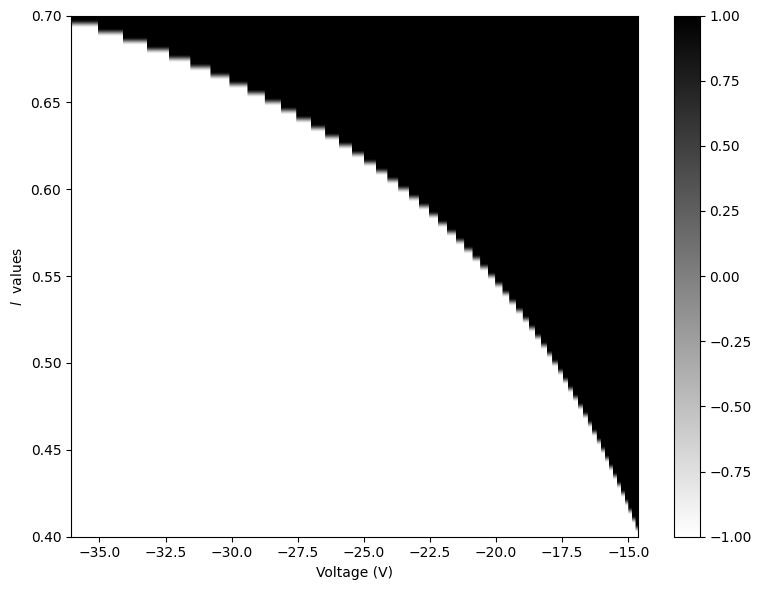

In [9]:
import matplotlib.pyplot as plt

# Assuming Jsign_func1 is your heatmap data for signs_J1

# Plot the heatmap for signs_J1 only
fig, ax = plt.subplots(figsize=(8, 6))

img1 = ax.imshow(Jsign_func1, cmap='binary', extent=[V_range[0], V_range[-1], L_values[0], L_values[-1]],
                 aspect='auto', vmin=-1, vmax=1)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('$l~$ values')
#ax.set_title(r'Heatmap for signs of $(J_{k0,0}+J_{k0,1} Q + J_{k1,0}d )~ J_{k1,1}$')
ax.set_xlim(min_V, max_V)
#ax.set_ylim(L_values[0], L_values[-1])  # Reverse the y-axis

# Add colorbar
fig.colorbar(img1, ax=ax)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [10]:
# Define the ranges for L and R
L = 0.1
R_values = np.linspace(0.07, 0.095, 60)
#L_values = [0.05,  0.95, 1.05,  2]
Q = 0.001

# Initialize matrices for signs_J1 and signs_J2
lenR = len(R_values)
num_subintervals = 20

signs_J111 = np.zeros((lenR, num_subintervals))
signs_J211 = np.zeros((lenR, num_subintervals))
V_critic = np.zeros((lenR, num_subintervals))

# Initialize min_V and max_V for plots
min_V = 60  # Initialize to a positive large value
max_V = -60  # Initialize to a engative large value

for i, R in tqdm(enumerate(R_values), total=len(R_values), desc='Processing time'):
    print('R = ', R)
    V_range = np.linspace(-100, 100, int(1e7))  # Adjust the number of points as needed
    J110, J111, J211, J_1, J_1effect, J_1d_effect = fluxes(alpha, beta, z1, z2, L, R, V_range, lmbd, d)
    

    # Find indices of values very close to zero in J111
    epsilon = 1e-7  # Adjust this value as needed
    zero_indices1 = np.where(np.isclose(J_1d_effect, 0., atol=epsilon))[0]
    

    # Keep one element per consecutive sequence in zero_indices1 and zero_indices2
    zero_indices1 = keep_min_abs_per_consecutive(zero_indices1, J_1d_effect)
    

    # Get corresponding values of V_range for zero values in J1_prd2 and J2_prd2
    # Get corresponding values of V_range for zero values in J1_prd2 and J2_prd2
    V_zero_values1 = V_range[zero_indices1.astype(int)]
   
    # Rearrange to have V_zero
    V_zero = np.sort(V_zero_values1)

    # Remove close values in V_combined
    V_zero = remove_close_roots(V_zero, V_range)
    #print('V_zero_new:', V_zero)

    lng = len(V_zero)
    # Create new subintervals using np.linspace
    if lng > 0:
        min_V = min(min_V, np.min(V_zero))
        max_V = max(max_V, np.max(V_zero))
        subintervals = [
                  np.linspace(V_zero[0]-80, V_zero[0], num_subintervals)
                ] + [
                  np.linspace(V_zero[i], V_zero[i + 1], num_subintervals) for i in range(lng - 1)
                ] + [
                  np.linspace(V_zero[-1], V_zero[-1]+80, num_subintervals)
                ]
        
        #print('subintervals:',subintervals)
    else:
        subintervals = [np.linspace(V_range[0], V_range[-1], num_subintervals)]
        #print('subintervals:',subintervals)
    


    signs_J111_temp = np.zeros(num_subintervals)
    
    for k, interval in enumerate(subintervals):
        start_point = interval[0]
        end_point = interval[-1]
        interval_range = np.linspace(start_point, end_point, num_subintervals)
        J110, J111, J211, J_1, J_1effect, J_1d_effect = fluxes(alpha, beta, z1, z2, L, R, interval_range, lmbd, d)

        midpoint = (start_point + end_point) / 2
        # Find the index in interval_range closest to the midpoint
        mid_index = np.abs(interval_range - midpoint).argmin()

        #mid_value = interval_range[midpoint_index]

        # Append the signs for the current L
        sign_J111 = np.sign(J_1d_effect[mid_index])
        

        # Append the signs for the current L to the temporary arrays
        signs_J111_temp[k] = 1 if sign_J111 > 0 else -1
      
    # Assign the temporary arrays to the i-th row of signs_J1 and signs_J2
    signs_J111[i, :] = signs_J111_temp
    V_critic[i, :lng] = V_zero

print("Minimum V_zero:", min_V)
print("Maximum V_zero:", max_V)

Processing time:   0%|          | 0/60 [00:00<?, ?it/s]

R =  0.07


Processing time:   2%|▏         | 1/60 [00:01<01:10,  1.20s/it]

R =  0.07042372881355932


Processing time:   3%|▎         | 2/60 [00:02<01:08,  1.19s/it]

R =  0.07084745762711865


Processing time:   5%|▌         | 3/60 [00:03<01:07,  1.19s/it]

R =  0.07127118644067797


Processing time:   7%|▋         | 4/60 [00:04<01:06,  1.19s/it]

R =  0.0716949152542373


Processing time:   8%|▊         | 5/60 [00:05<01:05,  1.20s/it]

R =  0.07211864406779661


Processing time:  10%|█         | 6/60 [00:07<01:04,  1.20s/it]

R =  0.07254237288135594


Processing time:  12%|█▏        | 7/60 [00:08<01:03,  1.20s/it]

R =  0.07296610169491526


Processing time:  13%|█▎        | 8/60 [00:09<01:02,  1.20s/it]

R =  0.07338983050847459


Processing time:  15%|█▌        | 9/60 [00:10<01:00,  1.20s/it]

R =  0.0738135593220339


Processing time:  17%|█▋        | 10/60 [00:11<00:59,  1.19s/it]

R =  0.07423728813559323


Processing time:  18%|█▊        | 11/60 [00:13<00:58,  1.19s/it]

R =  0.07466101694915254


Processing time:  20%|██        | 12/60 [00:14<00:57,  1.20s/it]

R =  0.07508474576271187


Processing time:  22%|██▏       | 13/60 [00:15<00:56,  1.20s/it]

R =  0.07550847457627119


Processing time:  23%|██▎       | 14/60 [00:16<00:55,  1.20s/it]

R =  0.07593220338983052


Processing time:  25%|██▌       | 15/60 [00:17<00:54,  1.20s/it]

R =  0.07635593220338983


Processing time:  27%|██▋       | 16/60 [00:19<00:52,  1.20s/it]

R =  0.07677966101694916


Processing time:  28%|██▊       | 17/60 [00:20<00:51,  1.20s/it]

R =  0.07720338983050848


Processing time:  30%|███       | 18/60 [00:21<00:50,  1.20s/it]

R =  0.0776271186440678


Processing time:  32%|███▏      | 19/60 [00:22<00:49,  1.20s/it]

R =  0.07805084745762712


Processing time:  33%|███▎      | 20/60 [00:23<00:47,  1.20s/it]

R =  0.07847457627118645


Processing time:  35%|███▌      | 21/60 [00:25<00:46,  1.20s/it]

R =  0.07889830508474577


Processing time:  37%|███▋      | 22/60 [00:26<00:45,  1.20s/it]

R =  0.07932203389830508


Processing time:  38%|███▊      | 23/60 [00:27<00:44,  1.20s/it]

R =  0.07974576271186441


Processing time:  40%|████      | 24/60 [00:28<00:43,  1.20s/it]

R =  0.08016949152542373


Processing time:  42%|████▏     | 25/60 [00:29<00:42,  1.21s/it]

R =  0.08059322033898306


Processing time:  43%|████▎     | 26/60 [00:31<00:40,  1.20s/it]

R =  0.08101694915254237


Processing time:  45%|████▌     | 27/60 [00:32<00:39,  1.20s/it]

R =  0.0814406779661017


Processing time:  47%|████▋     | 28/60 [00:33<00:38,  1.20s/it]

R =  0.08186440677966102


Processing time:  48%|████▊     | 29/60 [00:34<00:37,  1.20s/it]

R =  0.08228813559322035


Processing time:  50%|█████     | 30/60 [00:35<00:35,  1.20s/it]

R =  0.08271186440677966


Processing time:  52%|█████▏    | 31/60 [00:37<00:34,  1.20s/it]

R =  0.08313559322033899


Processing time:  53%|█████▎    | 32/60 [00:38<00:33,  1.20s/it]

R =  0.0835593220338983


Processing time:  55%|█████▌    | 33/60 [00:39<00:32,  1.21s/it]

R =  0.08398305084745764


Processing time:  57%|█████▋    | 34/60 [00:40<00:31,  1.21s/it]

R =  0.08440677966101695


Processing time:  58%|█████▊    | 35/60 [00:42<00:30,  1.21s/it]

R =  0.08483050847457627


Processing time:  60%|██████    | 36/60 [00:43<00:29,  1.21s/it]

R =  0.0852542372881356


Processing time:  62%|██████▏   | 37/60 [00:44<00:27,  1.21s/it]

R =  0.08567796610169492


Processing time:  63%|██████▎   | 38/60 [00:45<00:26,  1.21s/it]

R =  0.08610169491525424


Processing time:  65%|██████▌   | 39/60 [00:46<00:25,  1.21s/it]

R =  0.08652542372881356


Processing time:  67%|██████▋   | 40/60 [00:48<00:24,  1.22s/it]

R =  0.08694915254237288


Processing time:  68%|██████▊   | 41/60 [00:49<00:23,  1.23s/it]

R =  0.08737288135593221


Processing time:  70%|███████   | 42/60 [00:50<00:21,  1.22s/it]

R =  0.08779661016949153


Processing time:  72%|███████▏  | 43/60 [00:51<00:20,  1.21s/it]

R =  0.08822033898305084


Processing time:  73%|███████▎  | 44/60 [00:52<00:19,  1.21s/it]

R =  0.08864406779661017


Processing time:  75%|███████▌  | 45/60 [00:54<00:18,  1.21s/it]

R =  0.08906779661016949


Processing time:  77%|███████▋  | 46/60 [00:55<00:16,  1.21s/it]

R =  0.08949152542372882


Processing time:  78%|███████▊  | 47/60 [00:56<00:15,  1.22s/it]

R =  0.08991525423728813


Processing time:  80%|████████  | 48/60 [00:57<00:14,  1.21s/it]

R =  0.09033898305084746


Processing time:  82%|████████▏ | 49/60 [00:59<00:13,  1.22s/it]

R =  0.09076271186440678


Processing time:  83%|████████▎ | 50/60 [01:00<00:12,  1.22s/it]

R =  0.09118644067796611


Processing time:  85%|████████▌ | 51/60 [01:01<00:10,  1.22s/it]

R =  0.09161016949152542


Processing time:  87%|████████▋ | 52/60 [01:02<00:09,  1.22s/it]

R =  0.09203389830508474


Processing time:  88%|████████▊ | 53/60 [01:03<00:08,  1.21s/it]

R =  0.09245762711864407


Processing time:  90%|█████████ | 54/60 [01:05<00:07,  1.21s/it]

R =  0.0928813559322034


Processing time:  92%|█████████▏| 55/60 [01:06<00:06,  1.22s/it]

R =  0.09330508474576271


Processing time:  93%|█████████▎| 56/60 [01:07<00:04,  1.21s/it]

R =  0.09372881355932203


Processing time:  95%|█████████▌| 57/60 [01:08<00:03,  1.22s/it]

R =  0.09415254237288136


Processing time:  97%|█████████▋| 58/60 [01:09<00:02,  1.21s/it]

R =  0.09457627118644069


Processing time:  98%|█████████▊| 59/60 [01:11<00:01,  1.21s/it]

R =  0.095


Processing time: 100%|██████████| 60/60 [01:12<00:00,  1.21s/it]

Minimum V_zero: 32.68765326876533
Maximum V_zero: 63.823176382317655


In [11]:
# Create a matrix to store the heatmap values
Jsign_func1 = np.zeros((lenR, len(V_range)))
for i in range(len(V_critic)):
    left_index = np.searchsorted(V_range,V_critic[i, 0])
    #print('left=',V_range[left_index])
    #print('left=',left_index)
    Jsign_func1[i, :left_index] = -signs_J111[i, 0]

    for j in range(len(V_critic[i]) - 1):
        if (V_critic[i, j] == 0 and V_critic[i, j+1] == 0) :
            break

        elif (V_critic[i, j] != 0 and V_critic[i, j+1] == 0) :
            right_index = np.searchsorted(V_range,V_critic[i, j])
            #print('right=',V_range[right_index])
            Jsign_func1[i, right_index:] = -signs_J111[i, j+1]

        # Find the indices corresponding to the current segment
        else:
            start_index = np.searchsorted(V_range, V_critic[i, j])
            end_index = np.searchsorted(V_range, V_critic[i, j + 1])
            # Assign values from S to the corresponding segment in H
            Jsign_func1[i, start_index:end_index] = -signs_J111[i, j + 1]


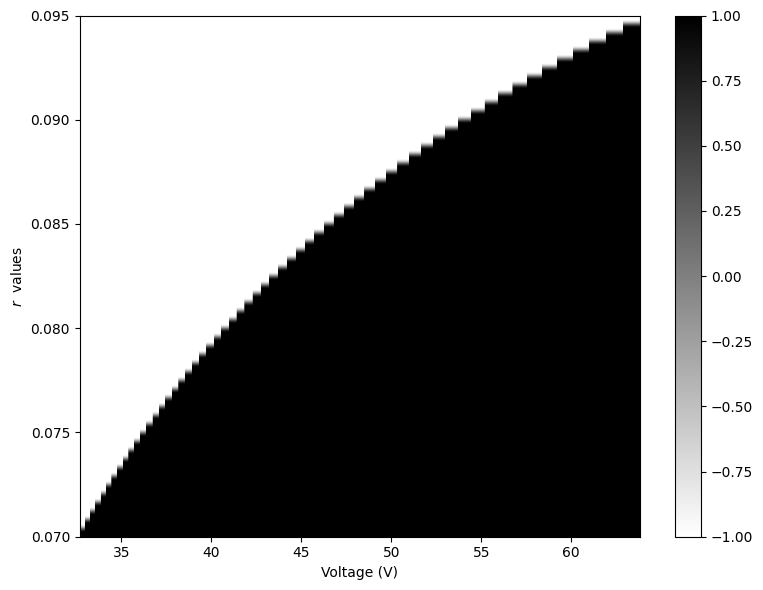

In [13]:
import matplotlib.pyplot as plt

# Assuming Jsign_func1 is your heatmap data for signs_J1

# Plot the heatmap for signs_J1 only
fig, ax = plt.subplots(figsize=(8, 6))

img1 = ax.imshow(Jsign_func1, cmap='binary', extent=[V_range[0], V_range[-1], R_values[0], R_values[-1]],
                 aspect='auto', vmin=-1, vmax=1)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('$r~$ values')
#ax.set_title(r'Heatmap for signs of $(J_{k0,0}+J_{k0,1} Q + J_{k1,0}d )~ J_{k1,1}$')
ax.set_xlim(min_V, max_V)
#ax.set_ylim(R_values[0], R_values[-1])  # Reverse the y-axis

# Add colorbar
fig.colorbar(img1, ax=ax)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
